# Prepare dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import string

possible_categories = [letter.lower() for i, letter in enumerate(string.ascii_uppercase) if letter not in ['J', 'Z']]
#possible_categories.append("*") # unknown symbol
#possible_categories.extend([str(x) for x in range(0, 10)]) # digits 0-9

possible_categories.remove("r") # Remove "r" as the quality in the converted dataset wasn't sufficient

def load_dataset_from_csv(path, keep_every=1):
    df = pd.read_csv(path, dtype={63: str}, header=None)
    df = df[df[63].notna() & df[63].apply(lambda l: str(l).lower()).isin(possible_categories)]
    if keep_every > 1:
        df = df[df.index % keep_every == 0]
    df[63] = df[63].apply(lambda l: l.lower())
    return df

In [3]:
# Load own dataset
my_dataset = load_dataset_from_csv("my_dataset.csv")

# Load mnist (converted)
mnist_df = load_dataset_from_csv("mnist_dataset.csv")
mnist_df = mnist_df[mnist_df[63] != "r"] # Need to remove r as it is mainly faulty

# Load exter (converted)
exter_df = pd.DataFrame()
for p in ["A", "B", "C", "D", "E"]:
    exported_df = load_dataset_from_csv(f"exter_{p}.csv")
    exter_df = pd.concat([exter_df, exported_df])
exter_df = exter_df[exter_df[63] != "r"] # Need to remove r as it is mainly faulty

In [4]:
def category_distrib(df, title=""):
    category_counts = df[63].value_counts()
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar')
    plt.xlabel('Kategóriák', fontname="Calibri")
    plt.ylabel('Minták száma', fontname="Calibri")
    plt.title(title, fontname="Calibri")
    #plt.savefig('Distribution of training dataset Categories.png', dpi=300)  # High resolution
    plt.show()

def equalize_category_counts(df, category_column, max_size=None):
    # Group by category and find the maximum size
    if not max_size:
        max_size = df.groupby(category_column).size().min()

    # Resample each group
    resampled = [group.sample(max_size, replace=True) for _, group in df.groupby(category_column)]

    # Concatenate the resampled groups
    return pd.concat(resampled, ignore_index=True)

In [5]:
from sklearn.model_selection import train_test_split

# Assuming train_df contains the landmarks in order
# A better way to separate train-valid split is to take the last x% of the data. If it's done randomly with shuffling similar datapoints may appear in the validation data.

# category_distrib(train_df, "train")
train_df = pd.concat([exter_df, mnist_df])
train_df = equalize_category_counts(train_df, 63)
# category_distrib(train_df, "train equalized")
test_df = my_dataset
# category_distrib(test_df, "test")

# Find unique categories
categories = train_df[63].unique()

train_list = []
valid_list = []
for category in categories:
    category_data = train_df[train_df[63] == category]
    # 80-20% split, shuffle must be False
    train_category, val_category = train_test_split(category_data, test_size=0.2, shuffle=False)
    train_list.append(train_category)
    valid_list.append(val_category)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(valid_list).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.524128,0.820911,-1.911725e-06,0.408463,0.936609,-0.017181,0.255223,0.960756,-0.030059,0.140540,...,0.265918,0.467451,-0.129117,0.338344,0.624951,-0.099863,0.392062,0.630225,-0.063611,a
1,0.685144,0.678148,-2.765598e-06,0.426989,0.615818,-0.099989,0.241890,0.456961,-0.142641,0.222038,...,0.889401,0.337496,-0.208225,0.839505,0.435589,-0.166106,0.806723,0.503401,-0.102613,a
2,0.472289,0.564534,-1.681803e-06,0.362614,0.538270,-0.044545,0.235327,0.435263,-0.064892,0.162639,...,0.533664,0.274477,-0.162339,0.496116,0.367112,-0.132737,0.517660,0.405464,-0.094523,a
3,0.396639,0.785245,4.565081e-07,0.587813,0.730548,-0.063449,0.758759,0.572098,-0.081522,0.849039,...,0.305791,0.335433,-0.040862,0.330488,0.354874,-0.023020,0.340789,0.383663,-0.001423,a
4,0.338622,0.629330,-3.231378e-06,0.248227,0.533088,-0.045193,0.273387,0.363678,-0.059277,0.328626,...,0.760271,0.425108,-0.209011,0.609534,0.482290,-0.154531,0.620734,0.521191,-0.088640,a


In [7]:
from tqdm import tqdm

def _move_hand_lms_to_middle(flat_xyz):
    # Reshape flat data to [num_samples, 3]
    xyz = flat_xyz.reshape((21, 3))
    xy = xyz[:, :2]

    # Compute the translation required to move the center of the bounding box to (0.5, 0.5)
    scaled_center = (np.min(xy, axis=0) + np.max(xy, axis=0)) / 2
    translation = [0.5, 0.5] - scaled_center

    translated_xy = xy + translation

    # Stitch back to original shape
    xyz = np.stack([translated_xy[:, 0], translated_xy[:, 1], xyz[:, 2]], axis=1)
    return np.reshape(xyz, [-1])

def move_hand_lms_to_middle(flat_xyz: np.ndarray):
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]

    # Reshape flat data to [num_samples, 21, 3]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))
    xy = xyz[:, :, :2]

    # Compute the translation required to move the center of the bounding box to (0.5, 0.5)
    min_coords = np.min(xy, axis=1)
    max_coords = np.max(xy, axis=1)
    scaled_centers = (min_coords + max_coords) / 2
    translations = np.array([[0.5, 0.5]] * batch_dim) - scaled_centers

    translated_xy = xy + translations[:, np.newaxis, :]

    # Stitch back to original shape
    xyz = np.concatenate([translated_xy, xyz[:, :, 2:]], axis=2)
    return xyz.reshape((batch_dim, -1))

def _scale_hand_lms(flat_xyz, target_size=0.55):
    # Reshape flat data to [num_samples, 3]
    xyz = flat_xyz.reshape((21, 3)) # 21 coords for the hands

    # Take only the x and y coordinates
    xy = xyz[:, :2]

    # Create a mask to ignore rows with NaN values
    mask = ~np.isnan(xy).any(axis=1)
    valid_landmarks = xy[mask]
    min_coords = np.min(valid_landmarks, axis=0)
    max_coords = np.max(valid_landmarks, axis=0)

    # Compute the scale factor
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    scale_factor = target_size / max(width, height)

    # Apply the scaling
    scaled_xy = xy * scale_factor

    xyz = np.stack([scaled_xy[:, 0], scaled_xy[:, 1], xyz[:, 2]], axis=1)
    flat_xyz = np.reshape(xyz, [-1])

    return move_hand_lms_to_middle(flat_xyz)

def scale_hand_lms(flat_xyz: np.ndarray, target_size=0.55) -> np.ndarray:
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]

    # Reshape flat data to [num_samples, 21, 3]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))

    # Take only the x and y coordinates
    xy = xyz[:, :, :2]

    # Replace NaN values with np.inf for min calculation and -np.inf for max calculation
    min_coords = np.nanmin(np.where(np.isnan(xy), np.inf, xy), axis=1)
    max_coords = np.nanmax(np.where(np.isnan(xy), -np.inf, xy), axis=1)

    # Compute the scale factor
    width = max_coords[:, 0] - min_coords[:, 0]
    height = max_coords[:, 1] - min_coords[:, 1]
    scale_factor = target_size / np.maximum(width, height)

    # Apply the scaling
    scaled_xy = xy * scale_factor[:, np.newaxis, np.newaxis]

    # Stitch back to original shape
    xyz = np.concatenate([scaled_xy, xyz[:, :, 2:]], axis=2)
    flat_xyz = xyz.reshape((batch_dim, -1))

    return move_hand_lms_to_middle(flat_xyz)

def nan_mean(x, axis=0, keepdims=False):
    """Function to calculate mean ignoring NaN values"""
    sum_x = np.nansum(x, axis=axis, keepdims=keepdims)
    count_x = np.sum(~np.isnan(x), axis=axis, keepdims=keepdims)
    return sum_x / count_x

def nan_std(x, axis=0, keepdims=False):
    """Function to calculate standard deviation ignoring NaN values"""
    center = nan_mean(x, axis=axis, keepdims=True)
    d = x - center
    return np.sqrt(nan_mean(d * d, axis=axis, keepdims=keepdims))

def preprocess_lms(lms: np.ndarray):
    if len(lms.shape) == 1:
        lms = np.array([lms])
    lms = scale_hand_lms(lms)
    mean = nan_mean(lms, axis=1)
    std = nan_std(lms, axis=1)
    lms = (lms-mean[:, np.newaxis]) / std[:, np.newaxis]
    return np.where(np.isnan(lms), 0., lms)

def processed_lms(df: pd.DataFrame) -> pd.DataFrame:
    lms = df.values[:, :-1].astype(np.float32)
    processed_lms = preprocess_lms(lms)
    preprocessed_df = pd.DataFrame(processed_lms)
    preprocessed_df[63] = df.values[:, -1]
    return preprocessed_df

In [8]:
train_df = processed_lms(train_df)
val_df = processed_lms(val_df)
test_df = processed_lms(test_df)

In [9]:
import torch
from typing import List
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder

class GraphDataset(InMemoryDataset):
    def __init__(self, df: pd.DataFrame, transform=None, pre_transform=None):
        self.label_encoder = LabelEncoder()
        self.connections = [(0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
                            (5,6), (5,9), (6,7), (7,8), (9,10), (9,13), 
                            (10,11), (11,12), (13,14), (13,17), (14,15), 
                            (15,16), (17,18), (18,19), (19,20)]

        super().__init__(None, transform, pre_transform)
        self.data_list = self.process_data(df)

    def process_data(self, df: pd.DataFrame) -> List[Data]:
        # Encode the categorical column
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])

        data_list = []
        for idx, row in df.iterrows():
            # Extract the 63 floats and reshape to (21, 3) for 3D node features
            node_features = np.array(row[:-1]).astype(np.float32).reshape(21, self.num_node_features)

            # Create the edge list and make it undirected by adding reverse connections
            edges = []
            for a, b in self.connections:
                edges.append([a, b])
                edges.append([b, a])  # Add the reverse connection

            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

            # Create the graph data object
            x = torch.tensor(node_features, dtype=torch.float)
            y = torch.tensor(labels[idx], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        return data_list
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))

    @property
    def num_node_features(self):
        return 3

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [10]:
train_dataset = GraphDataset(train_df)
val_dataset = GraphDataset(val_df)
test_dataset = GraphDataset(test_df)

print(f'Dataset: {train_dataset}:')
print('====================')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

data = train_dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: GraphDataset(27531):
Number of graphs: 27531
Number of features: 3
Number of classes: 23

Data(x=[21, 3], edge_index=[2, 42], y=0)
Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


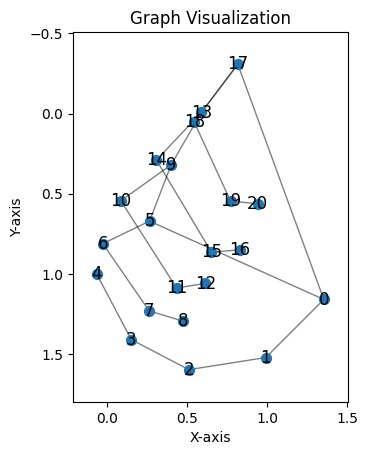

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(data):
    node_features = data.x.numpy()
    edge_index = data.edge_index.numpy()
    
    x = node_features[:, 0]
    y = node_features[:, 1]

    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    pos = {i: (x[i], y[i]) for i in range(len(x))}

    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot the graph on the given axis
    nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Invert the y-axis and set equal aspect ratio
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    # Enable ticks on both axes
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title("Graph Visualization")

    # Display the plot
    plt.show()

# Example usage
graph_data = train_dataset.get(0)
visualize_graph(graph_data)

In [12]:
from torch_geometric.loader import DataLoader

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for step, data in enumerate(train_loader):
    if step < 3:
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()
    else:
        break

Step 1:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 3], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 2:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 3], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])

Step 3:
Number of graphs in the current batch: 256
DataBatch(x=[5376, 3], edge_index=[2, 10752], y=[256], batch=[5376], ptr=[257])



In [29]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(train_dataset.num_node_features, hidden_channels, heads=1, concat=False)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False)
        self.conv3 = GATConv(hidden_channels, hidden_channels, heads=1, concat=False)
        self.conv4 = GATConv(hidden_channels, 64, heads=1, concat=False)
        self.lin = Linear(64, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256)
print(model)

GCN(
  (conv1): GATConv(3, 256, heads=1)
  (conv2): GATConv(256, 256, heads=1)
  (conv3): GATConv(256, 256, heads=1)
  (conv4): GATConv(256, 64, heads=1)
  (lin): Linear(in_features=64, out_features=23, bias=True)
)


In [58]:
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.01
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 100):
    train()
    val_acc = evaluate(val_loader)
    test_acc = evaluate(test_loader)
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Regular NN

In [47]:
from torch.utils.data import Dataset, DataLoader


class StaticASLFingerspellingDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        """
        Args:
            df (pd.DataFrame): DataFrame where the last column is the label.
        """
        self.features = torch.tensor(df.iloc[:, :-1].values.astype(np.float32), dtype=torch.float32)  # Convert features to tensors

        self.label_encoder = LabelEncoder()
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [48]:
batch_size = 256
nn_train_loader = DataLoader(StaticASLFingerspellingDataset(train_df), batch_size=batch_size, shuffle=True)
nn_valid_loader = DataLoader(StaticASLFingerspellingDataset(val_df), batch_size=batch_size, shuffle=True)
nn_test_loader = DataLoader(StaticASLFingerspellingDataset(test_df), batch_size=batch_size, shuffle=True)

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.05):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.silu(self.fc1(x))  # swish activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.silu(self.fc3(x))  # swish activation
        x = F.softmax(self.fc4(x), dim=1)
        return x

model = MLP(input_dim=63, output_dim=train_dataset.num_classes)
print(model)

MLP(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=23, bias=True)
)


In [59]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for x, y in nn_train_loader:
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            pred = out.argmax(dim=1)
            correct += int((pred == y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 100):
    train()
    val_acc = evaluate(nn_valid_loader)
    test_acc = evaluate(nn_test_loader)
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')